In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.conv4 = nn.Conv2d(128, 128, 3, 1)
        self.conv5 = nn.Conv2d(128, 256, 3, 1)
        self.pool = nn.MaxPool2d(2,2,0)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256*1*1, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512,10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        #x = self.dropout1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)


        #x = self.dropout2(x)

        x = F.relu(self.conv5(x))
        x = self.pool(x)

        #x = self.dropout3(x)

        x = x.view(-1, 256*1*1)
        #print(x.shape)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch,
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss,
        correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
    
    return all_preds, all_targets
    
def plot_confusion_matrix(conf_matrix, classes):
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Matriz de Confusión')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = conf_matrix.max() / 2.
    for i, j in np.ndindex(conf_matrix.shape):
        plt.text(j, i, format(conf_matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

    plt.ylabel('Etiqueta verdadera')
    plt.xlabel('Etiqueta predicha')
    plt.tight_layout()
    plt.show()

In [3]:
torch.manual_seed(42)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
train_kwargs = {'batch_size': 500}
test_kwargs = {'batch_size': 500}
if use_cuda:
    cuda_kwargs = {'num_workers': 1, 'pin_memory': True, 'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

transform = transforms.Compose([ transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,)) ])
dataset1 = datasets.CIFAR10('../data', train=True, download=True, transform=transform)
dataset2 = datasets.CIFAR10('../data', train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

model = Net().to(device)
optimizer = torch.optim.Adadelta(model.parameters(), lr=1.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7)
for epoch in range(50):
    train(model, device, train_loader, optimizer, epoch)
    all_preds, all_targets = test(model, device, test_loader)
    scheduler.step()

Files already downloaded and verified
Train Epoch: 0 [0/50000 (0%)]	Loss: 2.305772
Train Epoch: 0 [10000/50000 (20%)]	Loss: 2.275966
Train Epoch: 0 [20000/50000 (40%)]	Loss: 2.293555
Train Epoch: 0 [30000/50000 (60%)]	Loss: 2.303965
Train Epoch: 0 [40000/50000 (80%)]	Loss: 2.430153

Test set: Average loss: 2.2046, Accuracy: 1521/10000 (15%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.205569
Train Epoch: 1 [10000/50000 (20%)]	Loss: 2.165944
Train Epoch: 1 [20000/50000 (40%)]	Loss: 2.245567
Train Epoch: 1 [30000/50000 (60%)]	Loss: 1.989201
Train Epoch: 1 [40000/50000 (80%)]	Loss: 1.936106

Test set: Average loss: 1.8992, Accuracy: 3036/10000 (30%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.888301
Train Epoch: 2 [10000/50000 (20%)]	Loss: 1.899089
Train Epoch: 2 [20000/50000 (40%)]	Loss: 1.812279
Train Epoch: 2 [30000/50000 (60%)]	Loss: 1.979807
Train Epoch: 2 [40000/50000 (80%)]	Loss: 1.803524

Test set: Average loss: 1.7127, Accuracy: 3764/10000 (38%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.696392

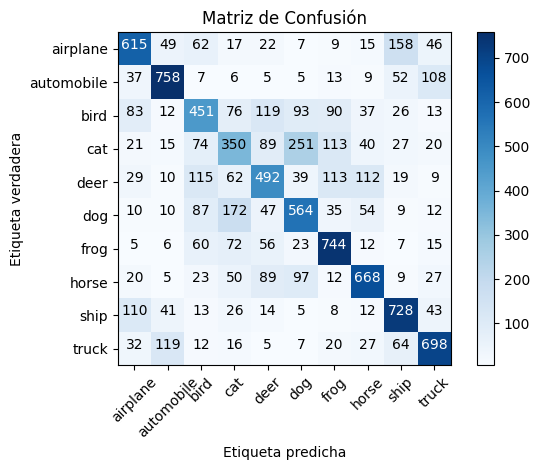

In [4]:
conf_matrix = metrics.confusion_matrix(all_targets, np.array(all_preds).flatten())
plot_confusion_matrix(conf_matrix, classes=dataset1.classes)